## Installs and imports

In [5]:
!pip install --upgrade pip #Standard pip upgrade
!pip install sentencepiece #Text tokeniser. More info: https://github.com/google/sentencepiece
!pip install transformers #HuggingFace API. More info: https://huggingface.co/docs/transformers/main/en/index

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from transformers import AutoTokenizer, AutoModel, AutoConfig #This will be used to create a class for the relevant architecture (Fit the correct model to the correct data)
from transformers import AutoModelForSequenceClassification #generic model class that goes along with the previous imports above
from torch.utils.data import DataLoader #PyTorch data loading utility
import numpy as np
from scipy.special import softmax #the softmax function (vector is transformed into another vector which sums to 1)
import pandas as pd

## Data

In [7]:
from google.colab import drive
drive.mount('/content/drive') #standard drive mounting


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv(r"/content/drive/MyDrive/TLS stuff/HINDI_dataset.csv") #fill in the directory of your csv as appropriate. Feel free to test it on other datsets in other languages!

In [9]:
df = df.astype(str).applymap(lambda x: x[:514]) #panda's version of map
print(df.head())
dataset = (df['review'])
#print (dataset.head(50))

                                              review sentiment
0  गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...         0
1  ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है         0
2  यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...         0
3  अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...         0
4                    कश्मीर में हो रहा है जल जिहाद ।         0


## Model

For the github page, visit "XLM-T - A Multilingual Language Model Toolkit for Twitter", https://github.com/cardiffnlp/xlm-t

In [10]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)
BATCH_SIZE = 1

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment" #chosen model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True) #use_fast simply loads the fast version of the Tokeniser
config = AutoConfig.from_pretrained(MODEL) # used for id to label name
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda') #This sends the parameters to the GPU assigned in CUDA = True
_ = model.eval()

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Forward

In [11]:
def forward(text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy() #cuda parametrisation
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [12]:
print (np.size(dataset))

first_N_messages = dataset [:9076] #usually this is used to test a subset of a massive database. In this case, we can just pass the maximum length as the prediction doesn't take too long
print (np.size(first_N_messages))

9076
9076


In [13]:
dl = DataLoader(first_N_messages, batch_size=BATCH_SIZE)
all_preds = []

for idx, batch in enumerate(dl):#parsing through each element
  text = batch
  if (text != "nan"): #if non empty input (we hope our dataset controllers take care of this anyway, but just in case)
    scores = forward(text, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    all_preds.extend(preds) #where the prediction actually happens

#print (all_preds)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [14]:
print (np.size(all_preds)) #to confirm how much of our sample actually got processed

9076


In [15]:
#print (all_preds) 
#optional print

In [16]:
print ("(0, 1, 2) predicted scores correspond to:") 
config.id2label[0], config.id2label[1], config.id2label[2] #labelling each of the scores accordingly

(0, 1, 2) predicted scores correspond to:


('Negative', 'Neutral', 'Positive')

In [17]:
for example in range(np.size(first_N_messages)):
  pred = all_preds[example]
  #print(first_N_messages[example], '--->', config.id2label[pred]) 
#This shows, explicitly, each message processed, alongside each sentiment rating given.

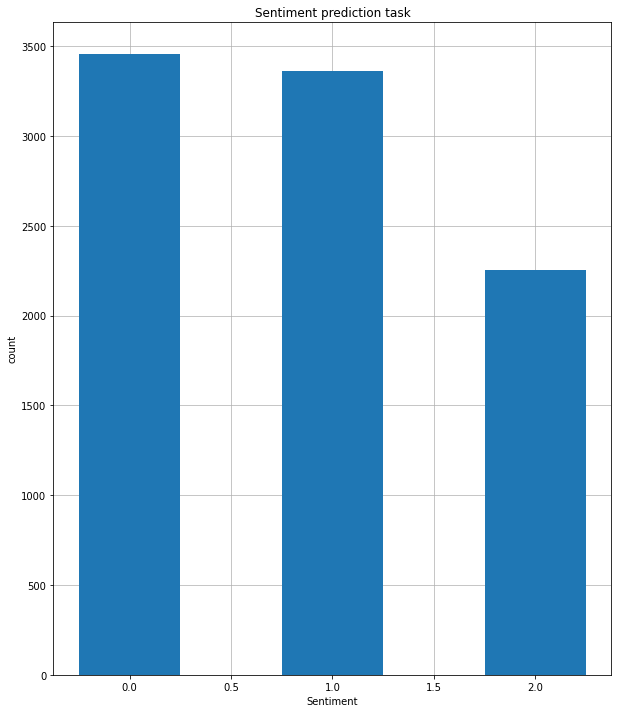

In [20]:
from matplotlib import pyplot as plt #now we plot our findings as a histogram
plt.figure(figsize=(10,12))
plt.grid(animated=True,alpha=0.9,zorder=-1)
plt.rcParams['axes.axisbelow'] = True
plt.hist(all_preds, bins=5, alpha=1,align="mid",range=[-0.25, 2.25])
plt.title('Sentiment prediction task')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

In [19]:
sentiment = (df['sentiment'])
Total=0
Correct=0
TP=0
FP=0
TN=0 #True Negative (Wasn't negative, model predicted it as such) isn't necessary for the analysis done here, but is worth mentioning perhaps.
FN=0
for i,j in zip (sentiment,all_preds):
  Total+=1
  if int(i)==int(j):
    Correct+=1 #We will measure total accuracy here
  if int(i)== 0 and int(j)==0: #Get true positives: Where positive means Negative Sentiment somewhat confusingly. We are looking for negative sentiment hence a correctly identified negative is a True Positive
    TP+=1
  if int(i) is not 0 and int(j)==0: #If it wasn't marked as negative, but the model predicted it as a negative, it's a False Positive.
    FP+=1
  if int(i)==0 and int(j) is not 0: #If it was marked as negative but the model failed to predict it as such, it's a False Negative.
    FN+=1
Accuracy=Correct/Total*100 #Standard Accuracy
Precision=(TP/(TP+FP))*100 #Formula for Precision
Recall=(TP/(TP+FN))*100 #Formula for Recall
Macro_F1=2*(Precision*Recall)/(Precision+Recall) #Formula for Macro-F1 score
print(Accuracy,"% Accuracy Rate") 
print(Precision,"% Precision") 
print(Recall,"% Recall") 
print(Macro_F1/100, "Macro-F1 score") #converting to decimal rather than having as a percentage

64.54385191714411 % Accuracy Rate
66.93641618497111 % Precision
72.99086038449417 % Recall
0.6983265490728178 Macro-F1 score
